# Imports and device detection

In [34]:
# Date time
import datetime as dt

# System
import sys

# Time
import time

# Matplotlib
import matplotlib.pyplot as plt

# NumPy
import numpy as np

# Pandas
import pandas as pd

# Seaborn
import seaborn as sns

# PyTorch framework
import torch
from torch import nn

# Device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {device}: {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
    print("No GPU found, using cpu")

Using cuda: NVIDIA GeForce RTX 3050 Laptop GPU


# Parameters

In [2]:
# Dictionary of model parameters
parameters = {}


def fillParameters(
    AF: str,  # Activation function
    AMPLITUDE: str,  # Amplitude function
    Nh: int,  # Number of nodes in each hidden layer
    D: int,  # Dimension of the coordinate space
    M: int,  # Number of states we want to find
    std: float,  # Standard deviation of sample distribution
    B: int,  # Batch size
    learningRate: float,  # Starting value of the learning rate (we use ADAM
    # optimizer)
    weightDecay: float,  # Weight decay (we use ADAM optimizer)
    wR: float,  # Residual term weight
    wA: float,  # Normalisation term weight
    wB: float,  # Orthogonalisation term weight
    wE: float,  # Energy term weight
    epsilon: float,  # Metropolis algorithm parameter
):
    """Fills dictionary of model parameters"""
    global parameters
    parameters["AF"] = AF
    parameters["AMPLITUDE"] = AMPLITUDE
    parameters["Nh"] = Nh
    parameters["D"] = D
    parameters["M"] = M
    parameters["std"] = std
    parameters["B"] = B
    parameters["learningRate"] = learningRate
    parameters["weightDecay"] = weightDecay
    parameters["wR"] = wR
    parameters["wA"] = wA
    parameters["wB"] = wB
    parameters["wE"] = wE
    s = "staticWeights"
    for key in parameters.keys():
        if key != "configuration":
            s = s + f"{key}{parameters[key]}"
    parameters["configuration"] = s  # Model configuration

# Activation functions

In [3]:
class Sin(nn.Module):
    """Custom sin activation function class"""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)

    def diff(self, x: torch.Tensor) -> torch.Tensor:
        return torch.cos(x)

    def diff2(self, x: torch.Tensor) -> torch.Tensor:
        return -torch.sin(x)


class Tanh(nn.Module):
    """Custom tanh activation function class"""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.tanh(x)

    def diff(self, x: torch.Tensor) -> torch.Tensor:
        return 1 / torch.cosh(x) ** 2

    def diff2(self, x: torch.Tensor) -> torch.Tensor:
        return -2 * torch.sinh(x) / torch.cosh(x) ** 3

# Amplitude functions

In [4]:
class Gaussian(nn.Module):
    """Custom Gaussian amplitude function class"""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        result = torch.ones((x.shape[0], parameters["M"])).to(device)
        result = torch.mul(result.t(), torch.exp(-torch.sum(x**2, axis=1) / 2)).t()
        assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
        assert result.shape[1] == parameters["M"], "Wrong shape 1 of the result"
        return result

    def gradient(self, x: torch.Tensor) -> torch.Tensor:
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        result = torch.ones((x.shape[0], parameters["D"], parameters["M"])).to(device)
        for d in range(parameters["D"]):
            # first term
            a = torch.ones((x.shape[0], parameters["M"])).to(device)
            a = torch.mul(
                a.t(),
                torch.exp(-torch.sum(x**2, axis=1) / 2) * (-2 * x[:, d] / 2),
            ).t()
            # keeping result
            result[:, d, :] = a
        assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
        assert result.shape[1] == parameters["D"], "Wrong shape 1 of the result"
        assert result.shape[2] == parameters["M"], "Wrong shape 2 of the result"
        return result

    def laplacian(self, x: torch.Tensor) -> torch.Tensor:
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        result = torch.ones((x.shape[0], parameters["M"])).to(device)
        result = torch.mul(
            result.t(),
            torch.exp(-torch.sum(x**2, axis=1) / 2)
            * (
                torch.sum((-2 * x / 2) ** 2, axis=1)
                - 2 * torch.sum(torch.ones_like(x) / 2, axis=1)
            ),
        ).t()
        assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
        assert result.shape[1] == parameters["M"], "Wrong shape 1 of the result"
        return result


class Exponent4(nn.Module):
    """Custom Exponent amplitude function class"""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        result = torch.ones((x.shape[0], parameters["M"])).to(device)
        result = torch.mul(
            result.t(),
            torch.exp(-torch.sum(x**4, axis=1) / parameters["std"] ** 4),
        ).t()
        assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
        assert result.shape[1] == parameters["M"], "Wrong shape 1 of the result"
        return result

    def gradient(self, x: torch.Tensor) -> torch.Tensor:
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        result = torch.ones((x.shape[0], parameters["D"], parameters["M"])).to(device)
        for d in range(parameters["D"]):
            # first term
            a = torch.ones((x.shape[0], parameters["M"])).to(device)
            a = torch.mul(
                a.t(),
                torch.exp(-torch.sum(x**4, axis=1) / parameters["std"] ** 4)
                * (-4 * x[:, d] ** 3 / parameters["std"] ** 4),
            ).t()
            # keeping result
            result[:, d, :] = a
        assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
        assert result.shape[1] == parameters["D"], "Wrong shape 1 of the result"
        assert result.shape[2] == parameters["M"], "Wrong shape 2 of the result"
        return result

    def laplacian(self, x: torch.Tensor) -> torch.Tensor:
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        result = torch.ones((x.shape[0], parameters["M"])).to(device)
        result = torch.mul(
            result.t(),
            torch.exp(-torch.sum(x**4, axis=1) / parameters["std"] ** 4)
            * (
                torch.sum((-4 * x**3 / parameters["std"] ** 4) ** 2, axis=1)
                - 12 * torch.sum(x**2 / parameters["std"] ** 4, axis=1)
            ),
        ).t()
        assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
        assert result.shape[1] == parameters["M"], "Wrong shape 1 of the result"
        return result

# Neural network (NN)

In [5]:
class NN(nn.Module):
    """Class for a neural network"""

    def __init__(self):
        super().__init__()
        global parameters
        if parameters["AF"] == "sin":
            self.AF = Sin()
        elif parameters["AF"] == "tanh":
            self.AF = Tanh()
        else:
            print("Wrong AF")
            sys.exit(1)
        # NUMBER OF HIDDEN LAYERS IS ASSUMED TO BE 3
        self.stack = nn.Sequential(
            nn.Linear(parameters["D"], parameters["Nh"]),
            self.AF,
            nn.Linear(parameters["Nh"], parameters["Nh"]),
            self.AF,
            nn.Linear(parameters["Nh"], parameters["Nh"]),
            self.AF,
            nn.Linear(parameters["Nh"], parameters["M"]),
            self.AF,
        )
        for i in range(len(self.stack)):
            if "weight" in dir(self.stack[i]):
                torch.nn.init.normal_(self.stack[i].weight, 0, np.sqrt(0.1))
        global device
        # chooseDevice()
        self.stack.to(device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        result = self.stack(x).to(device)
        assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
        assert result.shape[1] == parameters["M"], "Wrong shape 1 of the result"
        return result

    def gradient(self, x: torch.Tensor) -> torch.Tensor:
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        result = torch.ones((x.shape[0], parameters["D"], parameters["M"])).to(device)
        for d in range(parameters["D"]):
            ydiff = self.AF.diff(self.stack[0](x)) * self.stack[0].weight[:, d]
            y = self.stack[0 * 2 + 1](self.stack[0 * 2](x))
            # NUMBER OF HIDDEN LAYERS IS ASSUMED TO BE 3
            for i in range(1, 3 + 1):
                ydiff = self.AF.diff(self.stack[i * 2](y)) * torch.matmul(
                    ydiff, self.stack[i * 2].weight.t()
                )
                y = self.stack[i * 2 + 1](self.stack[i * 2](y))
            # keeping result
            result[:, d, :] = ydiff
        assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
        assert result.shape[1] == parameters["D"], "Wrong shape 1 of the result"
        assert result.shape[2] == parameters["M"], "Wrong shape 2 of the result"
        return result

    def laplacian(self, x: torch.Tensor) -> torch.Tensor:
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        preresult = torch.ones((x.shape[0], parameters["D"], parameters["M"])).to(
            device
        )
        for d in range(parameters["D"]):
            ydiff = self.AF.diff(self.stack[0](x)) * self.stack[0].weight[:, d]
            ydiff2 = self.AF.diff2(self.stack[0](x)) * self.stack[0].weight[:, d] ** 2
            y = self.stack[0 * 2 + 1](self.stack[0 * 2](x))
            # NUMBER OF HIDDEN LAYERS IS ASSUMED TO BE 3
            for i in range(1, 3 + 1):
                # second derivative
                ydiff2 = self.AF.diff2(self.stack[i * 2](y)) * torch.matmul(
                    ydiff, self.stack[i * 2].weight.t()
                ) ** 2 + self.AF.diff(self.stack[i * 2](y)) * torch.matmul(
                    ydiff2, self.stack[i * 2].weight.t()
                )
                # first derivative
                ydiff = self.AF.diff(self.stack[i * 2](y)) * torch.matmul(
                    ydiff, self.stack[i * 2].weight.t()
                )
                # output of the current layer
                y = self.stack[i * 2 + 1](self.stack[i * 2](y))
            # Keeping preresult
            preresult[:, d, :] = ydiff2
        result = torch.sum(preresult, axis=1)
        assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
        assert result.shape[1] == parameters["M"], "Wrong shape 1 of the result"
        return result

# Trial function

In [6]:
class TrialFunction(nn.Module):
    """Trial function class"""

    def __init__(self):
        super().__init__()
        self.nn = NN()
        global parameters
        if parameters["AMPLITUDE"] == "gaussian":
            self.amplitude = Gaussian()
        elif parameters["AMPLITUDE"] == "exponent4":
            self.amplitude = Exponent4()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        result = self.nn(x).to(device) * self.amplitude(x).to(device)
        assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
        assert result.shape[1] == parameters["M"], "Wrong shape 1 of the result"
        return result

    def gradient(self, x: torch.Tensor) -> torch.Tensor:
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        result = torch.ones((x.shape[0], parameters["D"], parameters["M"])).to(device)
        a = self.amplitude(x)
        ag = self.amplitude.gradient(x)
        nn = self.nn(x)
        nng = self.nn.gradient(x)
        for d in range(parameters["D"]):
            result[:, d, :] = nng[:, d, :] * a + nn * ag[:, d, :]
        assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
        assert result.shape[1] == parameters["D"], "Wrong shape 1 of the result"
        assert result.shape[2] == parameters["M"], "Wrong shape 2 of the result"
        return result

    def laplacian(self, x: torch.Tensor) -> torch.Tensor:
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        result = (
            self.nn.laplacian(x) * self.amplitude(x)
            + self.nn(x) * self.amplitude.laplacian(x)
            + 2 * torch.sum(self.nn.gradient(x) * self.amplitude.gradient(x), axis=1)
        )
        assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
        assert result.shape[1] == parameters["M"], "Wrong shape 1 of the result"
        return result

    def weight(self, x: torch.Tensor) -> torch.Tensor:
        """Weight function"""
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        result = torch.mean(self.forward(x) ** 2, axis=1)
        # result = (
        #     1
        #     / (parameters["std"] * float(np.sqrt(2 * np.pi))) ** parameters["D"]
        #     * torch.exp(-0.5 * torch.sum(x * x, axis=1) / parameters["std"] ** 2)
        # )
        assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
        return result

    def l2Norm(self, x: torch.Tensor) -> torch.Tensor:
        """Computes L2-norm of the trial function"""
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        result = torch.zeros(parameters["M"]).to(device)
        f = self.forward(x)
        w = self.weight(x)
        for m in range(parameters["M"]):
            result[m] = torch.mean(abs(f[:, m]) ** 2 / w)
        assert result.shape[0] == parameters["M"], "Wrong shape 0 of the result"
        return result

    def spectrum(self, x: torch.Tensor) -> torch.Tensor:
        """Finds current spectrum"""
        global parameters
        global device
        assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
        assert x.shape[1] == parameters["D"], "Wrong shape 1 of the tensor x"
        result = torch.zeros(parameters["M"]).to(device)
        f = self.forward(x)
        lap = self.laplacian(x)
        w = self.weight(x)
        v = 0.5 * torch.sum(x * x, axis=1)
        for m in range(parameters["M"]):
            result[m] = torch.mean(f[:, m] * (-0.5 * lap[:, m] + v * f[:, m]) / w)
        result = result / self.l2Norm(x)
        assert result.shape[0] == parameters["M"], "Wrong shape 0 of the result"
        return result

    def save(self):
        """Saves model weights and biases"""
        torch.save(
            self.state_dict(),
            "../models/" + parameters["configuration"] + ".pt",
        )

    def load(self):
        """Loads model weights and biases"""
        self.load_state_dict("../models/" + parameters["configuration"] + ".pt")

# Metropolis algorithm

In [7]:
def MetropolisAlghorithmStep(x, f):
    """One step of the Metropolis algorithm, it return the updated sample x"""
    global parameters
    x_prime = x + parameters["epsilon"] * (2 * torch.rand_like(x).to(device) - 1)
    alpha = f(x_prime).to(device) / f(x).to(device)
    doesXMove = torch.rand((x.shape[0])).to(device) <= alpha
    x_prime = (
        torch.mul(doesXMove.int(), x_prime.t()).t()
        + torch.mul((1 - doesXMove.int()), x.t()).t()
    )
    return x_prime

## Test

<Axes: ylabel='Density'>

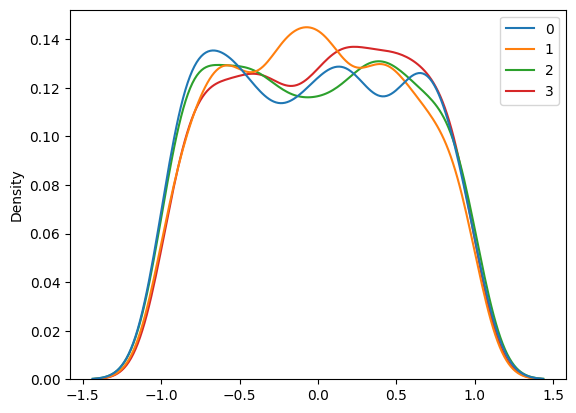

In [8]:
parameters["epsilon"] = 1
x = (2 * torch.rand((1000, 4)) - 1).to(device)
sns.kdeplot(x.cpu().detach().numpy())

In [9]:
def func(x):
    return torch.exp(-torch.sum(x**2, axis=1) / 2)


for i in range(10):
    x = MetropolisAlghorithmStep(x, func)

<Axes: ylabel='Density'>

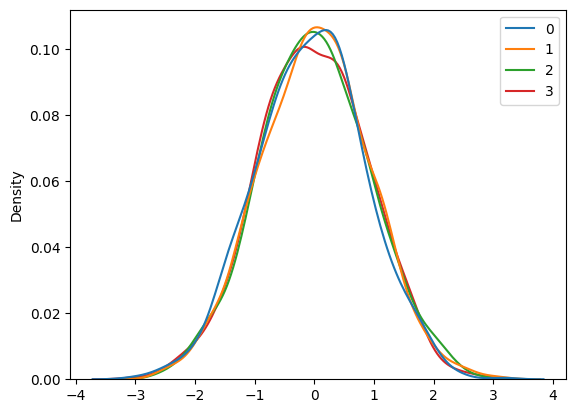

In [10]:
sns.kdeplot(x.cpu().detach().numpy())

# Training

In [11]:
def training(
    trialFunction: TrialFunction,  # Trial function we will train
    steps: int,  # Number of steps
):
    """Trains trial function"""
    global parameters
    global device
    print("Model configuration:")
    print(parameters["configuration"])
    print("")
    print("Training has been started...")
    print("")
    print(
        "Step, Time [s], Residual-term, Normalization-term,"
        + " Orthogonalization-term, Sorted energies"
    )
    time0 = time.time()
    time_history = np.full((steps), np.nan)
    loss_history = np.full((steps), np.nan)
    r_history = np.full((steps), np.nan)
    a_history = np.full((steps), np.nan)
    b_history = np.full((steps), np.nan)
    spectrum_history = np.full((parameters["M"], steps), np.nan)
    optimizer = torch.optim.AdamW(
        params=list(trialFunction.parameters()),
        lr=parameters["learningRate"],
        weight_decay=parameters["weightDecay"],
    )
    lossFunction = nn.MSELoss()
    for step in range(steps):
        # Sample
        if step == 0:
            x = parameters["std"] * (
                torch.rand((parameters["B"], parameters["D"])) - 0.5
            ).to(device)
        else:
            for i in range(10):
                x = MetropolisAlghorithmStep(x, trialFunction.weight)
        # Spectrum (Energies)
        e = trialFunction.spectrum(x)
        # Forward (trial function)
        f = trialFunction(x)
        # Laplacian
        lap = trialFunction.laplacian(x)
        # Weight function
        w = trialFunction.weight(x)
        # Squared norm
        sqrNorm = trialFunction.l2Norm(x)
        # R-term
        r = sum(
            [
                torch.mean(
                    (
                        -0.5 * lap[:, m]
                        + 0.5 * f[:, m] * torch.sum(x**2, axis=1)
                        - f[:, m] * e[m]
                    )
                    ** 2
                    / w
                )
                / sqrNorm[m]
                for m in range(parameters["M"])
            ]
        )
        # A-term
        a = torch.sum((sqrNorm - torch.tensor(1).to(device)) ** 2)
        # B-term
        b = torch.zeros(parameters["M"], parameters["M"]).to(device)
        for m1 in range(1, parameters["M"]):
            for m2 in range(0, m1):
                maxs = (torch.max(f[:, m1]) * torch.max(f[:, m2])).detach() + 0.001
                torch.Tensor.detach(maxs)
                b[m1, m2] = (
                    torch.square(torch.mean(f[:, m1] * f[:, m2] / w))
                    / sqrNorm[m1]
                    / sqrNorm[m2]
                )
        # The total loss
        loss = lossFunction(
            parameters["wR"] * r
            + parameters["wA"] * a
            + parameters["wB"] * torch.sum(b)
            + parameters["wE"] * torch.sum(e),
            torch.tensor(0.0).to(device),
        )
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save a state of the model
        time_ = time.time() - time0
        time_history[step] = time_
        if np.isnan(loss.item()):
            print("LOSS IS NAN")
            return
        loss_history[step] = loss.item()
        r_history[step] = r.cpu().detach().numpy()
        a_history[step] = a.cpu().detach().numpy()
        b_history[step] = torch.sum(b).cpu().detach().numpy()
        spectrum_history[:, step] = e.cpu().detach().numpy()
        # Release some memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        # Print the state of the model
        if step % 100 == 0:
            print(
                f"{step}, {time_:.2f}, {r_history[step]:.4e},"
                + f" {a_history[step]:.4e}, {b_history[step]:.4e},"
                + f" {np.sort(spectrum_history[:, step])}"
            )
    # Save history
    d = {
        "Time[s]": time_history,
        "R-term": r_history,
        "A-term": a_history,
        "B-term": b_history,
    }
    for i in range(parameters["M"]):
        d[f"e{i}"] = spectrum_history[i, :]
    history_df = pd.DataFrame(data=d)
    now = dt.datetime.now()
    dt_string = now.strftime("%d.%m.%Y_%H:%M:%S")
    history_df.to_csv("../data/" + dt_string + parameters["configuration"] + ".csv")
    return history_df

# 3D Test

In [57]:
fillParameters(
    AF="sin",  # Activation function
    AMPLITUDE="gaussian",  # Amplitude function
    Nh=100,  # Number of nodes in each hidden layer
    D=3,  # Dimension of the coordinate space
    M=5,  # Number of states we want to find
    std=3,  # Standard deviation of sample distribution
    B=int(2 ** (10 + 3)),  # Batch size
    learningRate=1e-3,  # Starting value of the learning rate (we use ADAM
    # optimizer)
    weightDecay=1e-3,  # Weight decay (we use ADAM optimizer)
    wR=1,  # Residual term weight
    wA=1,  # Normalisation term weight
    wB=40,  # Orthogonalisation term weight
    wE=1,  # Energy term weight
    epsilon=1,  # Metropolis algorithm parameter
)

tf = TrialFunction()
tf.to(device)

STEPS = 15000

history = training(
    trialFunction=tf,  # Trial function we will train
    steps=STEPS,  # Number of steps
)

Model configuration:
staticWeightsepsilon1AFsinAMPLITUDEgaussianNh100D4M5std3B16384learningRate0.001weightDecay0.001wR1wA1wB40wE1

Training has been started...

Step, Time [s], Residual-term, Normalization-term, Orthogonalization-term, Sorted energies


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.81 GiB total capacity; 2.43 GiB already allocated; 12.31 MiB free; 2.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [26]:
tf.save()

In [27]:
history.columns

Index(['Time[s]', 'R-term', 'A-term', 'B-term', 'e0', 'e1', 'e2', 'e3', 'e4'], dtype='object')

## How many time it takes

In [28]:
t = history["Time[s]"].to_numpy()[-1]
ht = int(t // 3600)
mt = int(t // 60 - ht * 60)
st = int(t - 3600 * ht - 60 * mt)
print(f"It takes {ht:}h {mt:}m {st}s")

It takes 0h 50m 45s


## Plotting

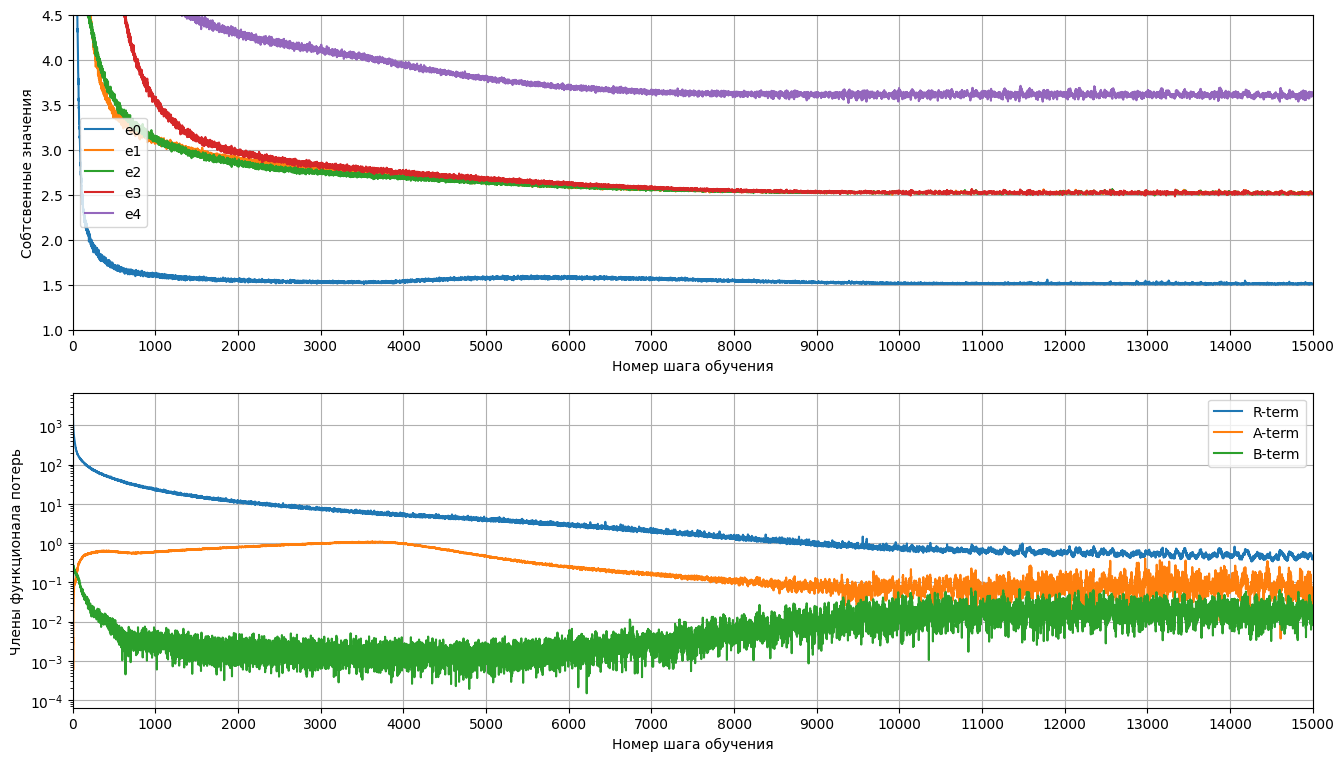

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(16, 9))

history[["e0", "e1", "e2", "e3", "e4"]].plot(
    legend=True,
    xlim=(0, STEPS),
    xticks=np.arange(0,STEPS+1,1000),
    grid=True,
    ax=ax[0],
    ylabel="Собтсвенные значения",
    xlabel="Номер шага обучения",
    logy=False,
    ylim=(1,4.5)
    # logx=True
)

history[["R-term", "A-term", "B-term"]].plot(
    legend=True,
    xlim=(0, STEPS),
    xticks=np.arange(0,STEPS+1,1000),
    grid=True,
    logy=True,
    ax=ax[1],
    ylabel="Члены функционала потерь",
    xlabel="Номер шага обучения"
)

plt.savefig(
    f"../images/energyLossFunction_Steps{STEPS}_"
    + parameters["configuration"]
    + ".pdf",
)
plt.show()

## Energies at the last step

In [49]:
history[["e0", "e1", "e2", "e3", "e4"]][-1:]

,e0,e1,e2,e3,e4
14999,1.507823,2.51373,2.515989,2.511297,3.611309


### Relative errors 

In [54]:
abs(float(history['e0'][-1:]) - 1.5) / 1.5

0.005215644836425781

In [55]:
abs(float(history['e1'][-1:]) - 2.5) / 2.5, abs(float(history['e2'][-1:]) - 2.5) / 2.5, abs(float(history['e3'][-1:]) - 2.5) / 2.5

(0.005492115020751953, 0.0063956260681152345, 0.004518699645996094)

In [56]:
abs(float(history['e4'][-1:]) - 3.5) / 3.5

0.031802518027169366

# 4D Test

In [12]:
fillParameters(
    AF="sin",  # Activation function
    AMPLITUDE="gaussian",  # Amplitude function
    Nh=100,  # Number of nodes in each hidden layer
    D=4,  # Dimension of the coordinate space
    M=5,  # Number of states we want to find
    std=3,  # Standard deviation of sample distribution
    B=int(2 ** (10 + 4)),  # Batch size
    learningRate=1e-3,  # Starting value of the learning rate (we use ADAM
    # optimizer)
    weightDecay=1e-3,  # Weight decay (we use ADAM optimizer)
    wR=1,  # Residual term weight
    wA=1,  # Normalisation term weight
    wB=40,  # Orthogonalisation term weight
    wE=1,  # Energy term weight
    epsilon=1,  # Metropolis algorithm parameter
)

tf = TrialFunction()
tf.to(device)

STEPS = 15000

history = training(
    trialFunction=tf,  # Trial function we will train
    steps=STEPS,  # Number of steps
)

Model configuration:
staticWeightsepsilon1AFsinAMPLITUDEgaussianNh100D4M5std3B16384learningRate0.001weightDecay0.001wR1wA1wB40wE1

Training has been started...

Step, Time [s], Residual-term, Normalization-term, Orthogonalization-term, Sorted energies


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 3.81 GiB total capacity; 2.43 GiB already allocated; 320.00 KiB free; 2.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## How many time it takes

In [33]:
t = history["Time[s]"].to_numpy()[-1]
ht = int(t // 3600)
mt = int(t // 60 - ht * 60)
st = int(t - 3600 * ht - 60 * mt)
print(f"It takes {ht:}h {mt:}m {st}s")

It takes 1h 23m 11s


## Plotting

In [32]:
history = pd.read_csv("../data/history4D.csv")
history

,Step,Time[s],Residual-term,Normalization-term,Orthogonalization-term,e0,e1,e2,e3,e4
0,0,2.05,7500.30000,0.000144,0.004153,33.506916,34.612503,35.477112,40.844116,50.324581
1,100,35.64,408.15000,0.043526,0.026344,9.791117,10.998326,12.198651,12.257004,12.596474
2,200,69.30,272.44000,0.074224,0.019478,7.825697,10.116706,11.226274,11.365164,11.439441
3,300,105.18,216.39000,0.094589,0.012425,7.093422,9.496285,10.491733,10.507340,10.603872
4,400,138.99,172.23000,0.116010,0.009764,6.410403,9.004139,9.851228,10.020741,10.092412
...,...,...,...,...,...,...,...,...,...,...
145,14500,4857.94,0.50872,0.025706,0.017700,2.008832,3.023334,3.032202,3.032930,3.034117
146,14600,4891.28,0.52464,0.036788,0.024594,2.010113,3.019793,3.024703,3.031949,3.035991
147,14700,4924.82,0.51169,0.008163,0.016529,2.017562,3.033041,3.033933,3.037459,3.038585
148,14800,4958.27,0.46914,0.010764,0.007495,2.009390,3.027253,3.027809,3.032730,3.039687


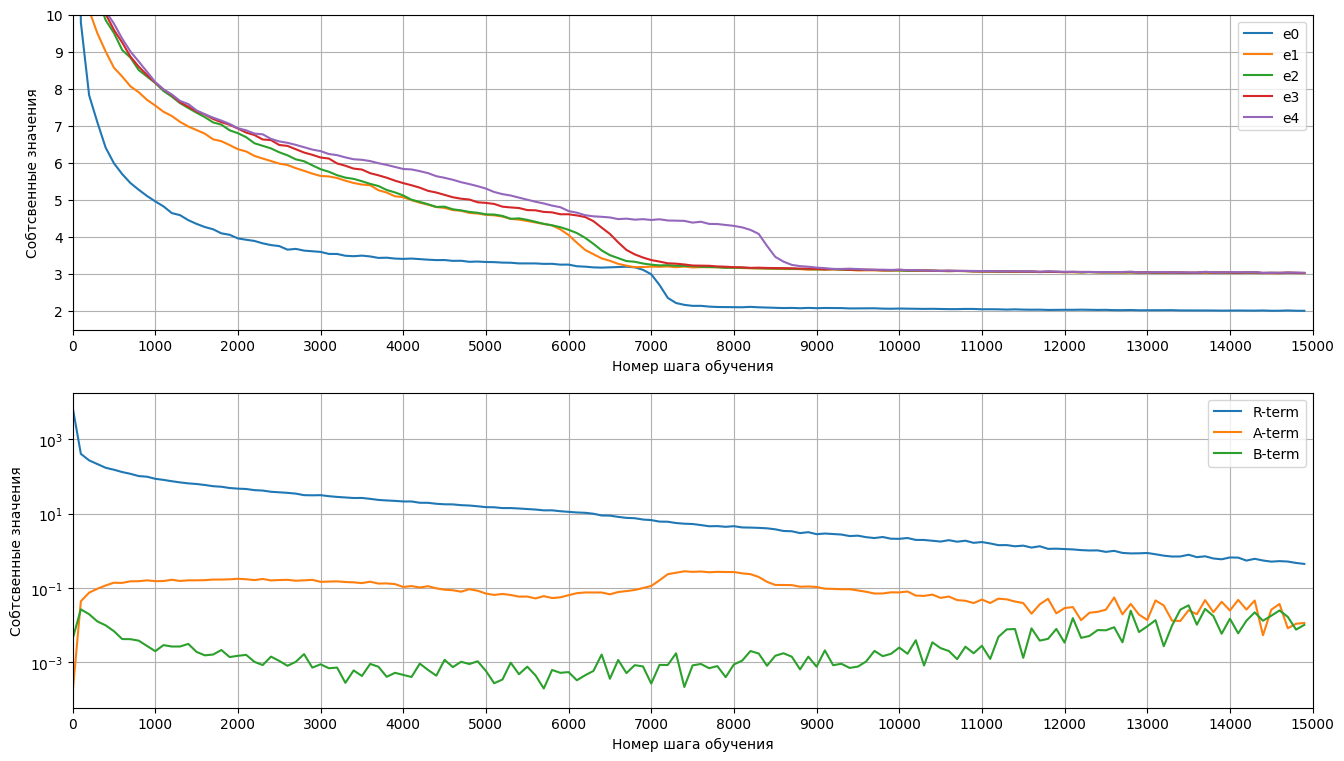

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(16, 9))

ax[0].plot(history['Step'].to_numpy(), history['e0'].to_numpy(), label='e0')
ax[0].plot(history['Step'].to_numpy(), history['e1'].to_numpy(), label='e1')
ax[0].plot(history['Step'].to_numpy(), history['e2'].to_numpy(), label='e2')
ax[0].plot(history['Step'].to_numpy(), history['e3'].to_numpy(), label='e3')
ax[0].plot(history['Step'].to_numpy(), history['e4'].to_numpy(), label='e4')

ax[0].legend()
ax[0].grid()
ax[0].set_xlim(0, 15000)
ax[0].set_ylim((1.5,10))
ax[0].set_xticks(np.arange(0,15000+1,1000))
ax[0].set_ylabel("Собтсвенные значения")
ax[0].set_xlabel("Номер шага обучения")

ax[1].plot(history['Step'].to_numpy(), history['Residual-term'].to_numpy(), label='R-term')
ax[1].plot(history['Step'].to_numpy(), history['Normalization-term'].to_numpy(), label='A-term')
ax[1].plot(history['Step'].to_numpy(), history['Orthogonalization-term'].to_numpy(), label='B-term')


ax[1].legend()
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_xlim(0, 15000)
# ax[1].set_ylim((1.5,10))
ax[1].set_xticks(np.arange(0,15000+1,1000))
ax[1].set_ylabel("Собтсвенные значения")
ax[1].set_xlabel("Номер шага обучения")

plt.savefig("../images/staticWeightsepsilon1AFsinAMPLITUDEgaussianNh100D4M5std3B16384learningRate0.001weightDecay0.001wR1wA1wB40wE1.pdf")

## Energies at the last step

In [19]:
history[["e0", "e1", "e2", "e3", "e4"]][-1:]

,e0,e1,e2,e3,e4
149,2.008083,3.025895,3.026578,3.026657,3.035008


In [30]:
abs(float(history['e0'][-1:]) - 2) / 2

0.004041670000000108

In [29]:
abs(float(history['e1'][-1:]) - 3) / 3, abs(float(history['e2'][-1:]) - 3) / 3, abs(float(history['e3'][-1:]) - 3) / 3, abs(float(history['e4'][-1:]) - 3) / 3

(0.008631626666666689,
 0.00885939666666665,
 0.008885623333333351,
 0.011669316666666596)

In [31]:
float(history['Times[s]'][-1:])

KeyError: 'Times[s]'